In [1]:
import numpy as np

import matplotlib.pyplot as plt
from h5py import File
%matplotlib inline

from jax import numpy as jnp
import jax
from tqdm import tqdm

from numpyro.infer import MCMC, NUTS, util, init_to_sample

import csiborgtools
import corner

%load_ext autoreload
%autoreload 2


paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)

## LOS density & radial velocity plots 

In [14]:
# fpath = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"
fpath = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"

loader_carrick = csiborgtools.flow.DataLoader("Carrick2015", "LOSS", fpath, paths, ksmooth=0)
loader_csiborg = csiborgtools.flow.DataLoader("csiborg1", "LOSS", fpath, paths, ksmooth=0)
loader_csiborg2 = csiborgtools.flow.DataLoader("csiborg2_main", "LOSS", fpath, paths, ksmooth=0)

10:20:19: reading the catalogue.
10:20:19: reading the interpolated field.


100%|██████████| 1/1 [00:00<00:00, 84.48it/s]


10:20:19: calculating the radial velocity.


100%|██████████| 50/50 [00:00<00:00, 21608.99it/s]


10:20:19: reading the catalogue.
10:20:19: reading the interpolated field.


100%|██████████| 101/101 [00:02<00:00, 42.58it/s]


10:20:21: calculating the radial velocity.


100%|██████████| 50/50 [00:00<00:00, 351.66it/s]


10:20:22: reading the catalogue.
10:20:22: reading the interpolated field.


100%|██████████| 20/20 [00:00<00:00, 123.83it/s]


10:20:22: calculating the radial velocity.


100%|██████████| 50/50 [00:00<00:00, 1285.41it/s]


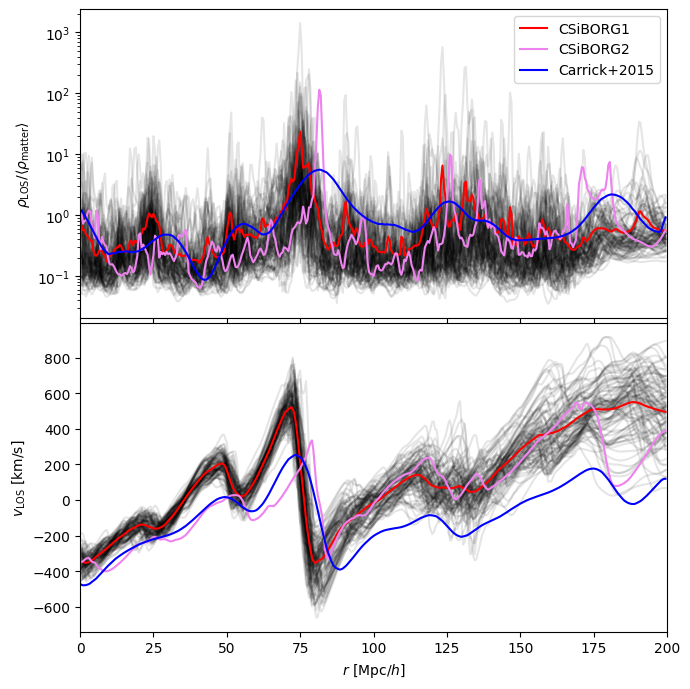

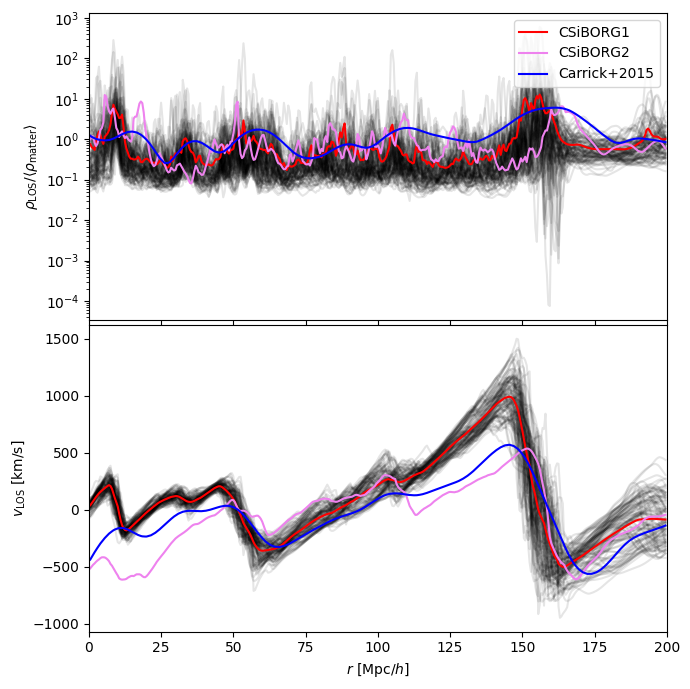

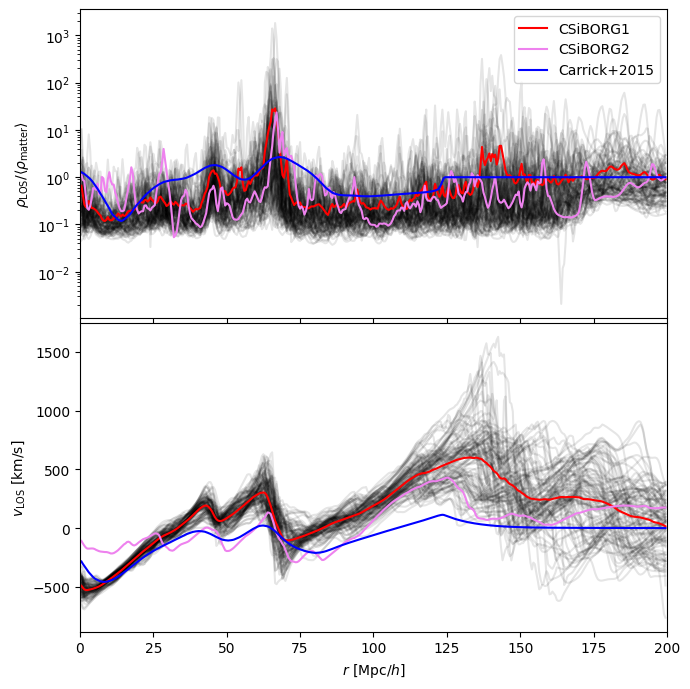

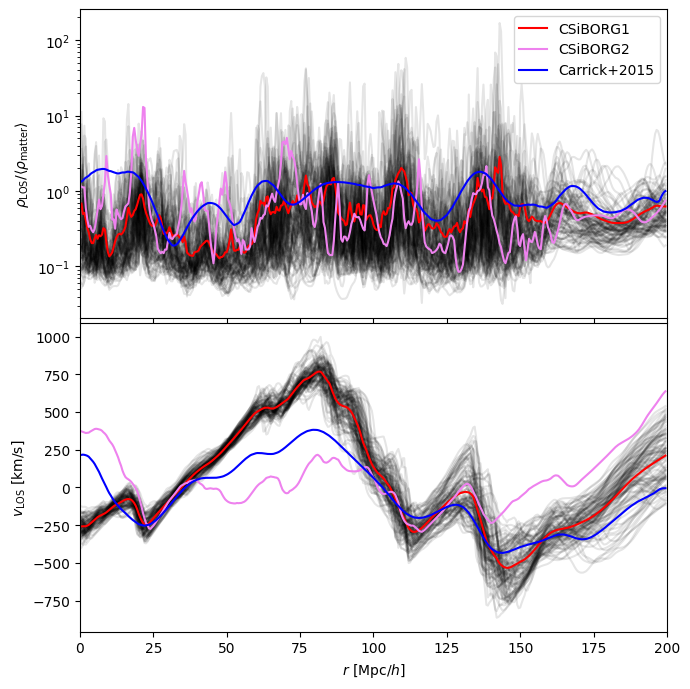

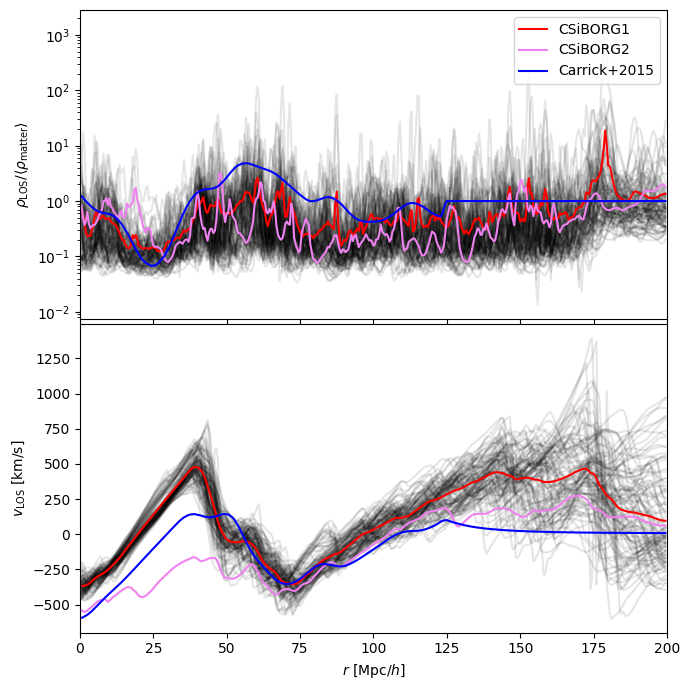

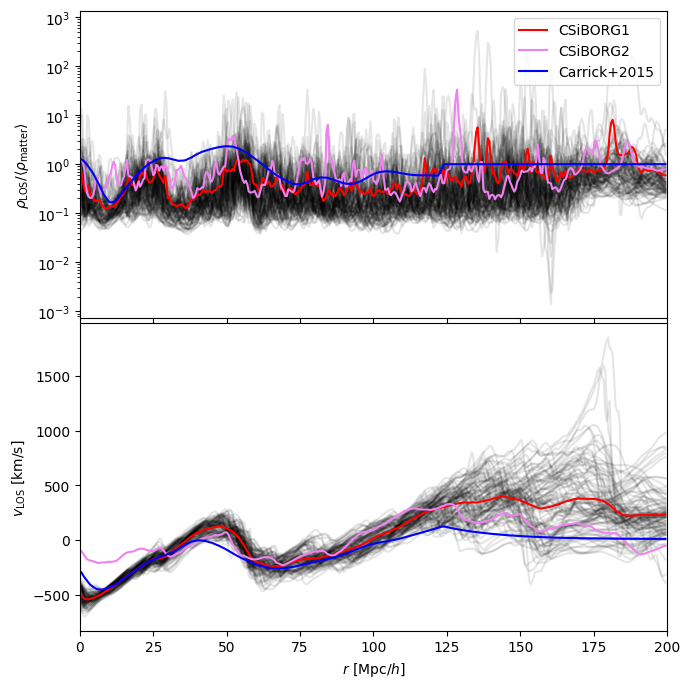

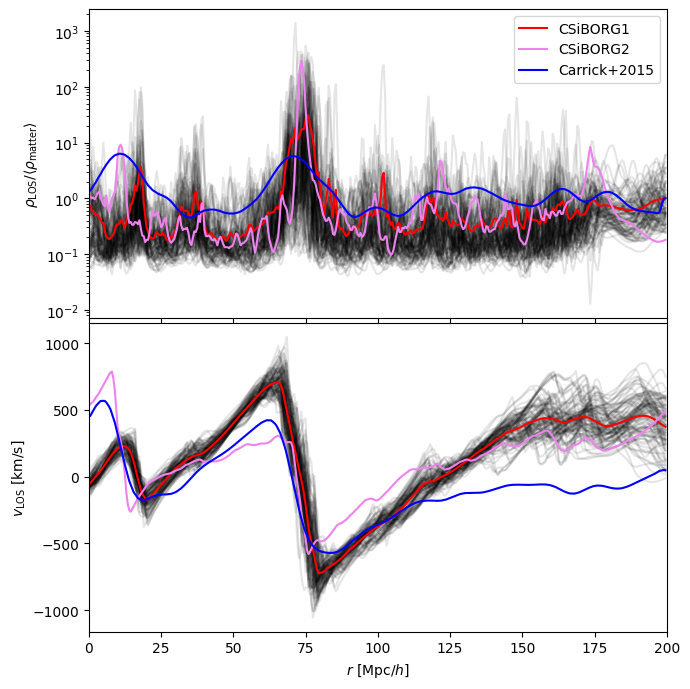

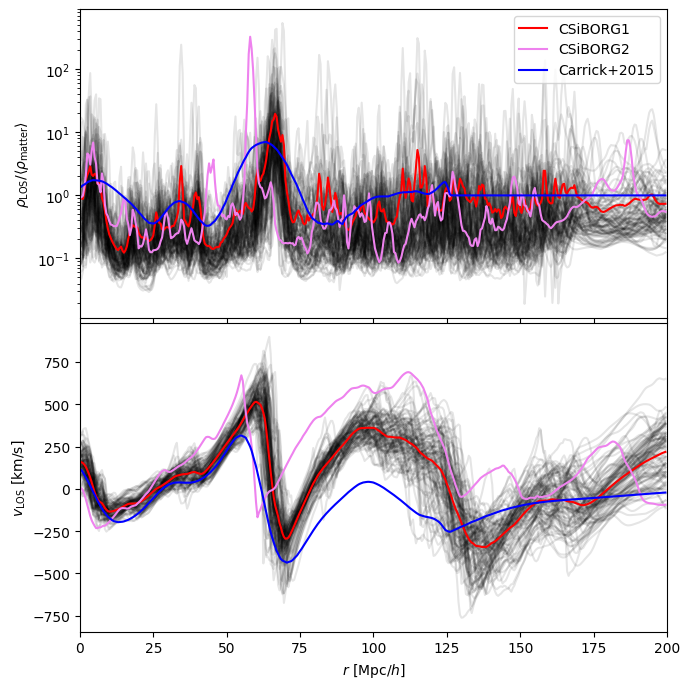

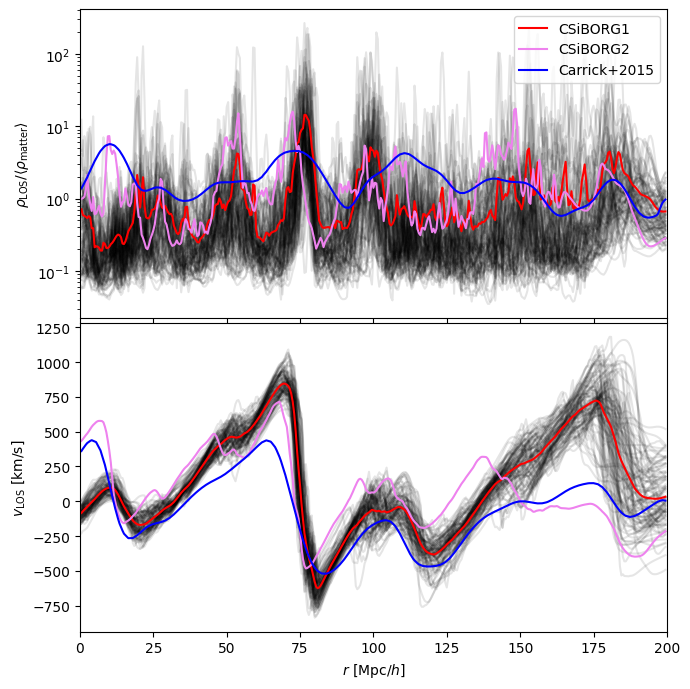

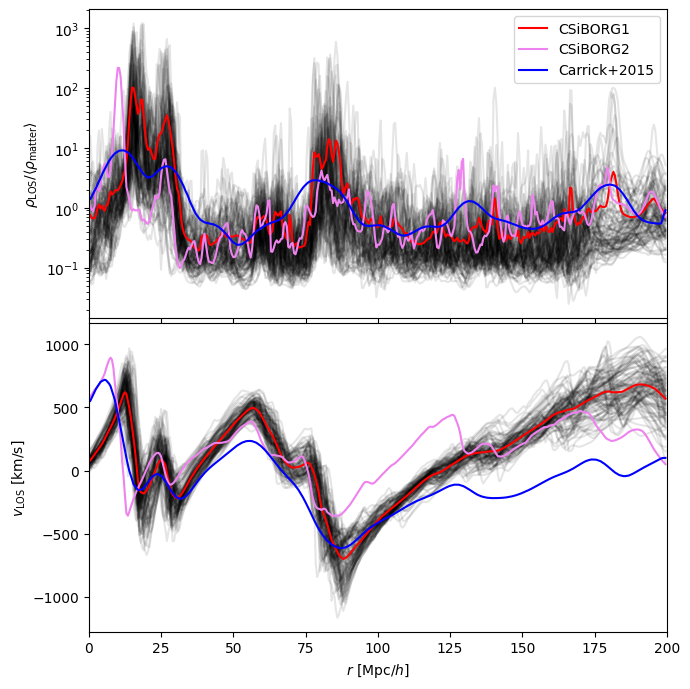

In [19]:
# ks = [115,  53,  77, 105,  26,  61,  86,  29,  80,  21]
ks = [19,  8, 15,  0, 16,  6, 48, 38, 26, 44]
# ks = [19]
# ks = np.random.choice(50, 10, replace=False)

# k = 6
for k in ks:
    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    # Get rid of vertical spacing
    fig.subplots_adjust(wspace=0)

    # Plot CSiBORG
    for i in range(loader_csiborg.los_density.shape[1]):
        axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, i, :], alpha=0.1, color="black")
        axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, i, :], alpha=0.1, color="black")

    # CSiBORG1
    axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, :, :].mean(axis=0), color="red", label="CSiBORG1")
    axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, :, :].mean(axis=0), color="red")

    # CSiBORG2
    axs[0].plot(loader_csiborg2.rdist, loader_csiborg2.los_density[k, :, :].mean(axis=0), color="violet", label="CSiBORG2")
    axs[1].plot(loader_csiborg2.rdist, loader_csiborg2.los_radial_velocity[k, :, :].mean(axis=0), color="violet")

    # Plot Carrick+2015
    axs[0].plot(loader_carrick.rdist, loader_carrick.los_density[k, 0, :], color="blue", label="Carrick+2015")
    axs[1].plot(loader_carrick.rdist, loader_carrick.los_radial_velocity[k, 0, :] * 0.43, color="blue")


    # for i in range(2):
    #     label = "SN"
    #     rdist = loader_csiborg.cat["r_hMpc"][k]
    #     axs[i].axvline(rdist, color="violet", linestyle="--",
    #                 zorder=0, label=label)

    axs[1].set_xlabel(r"$r ~ [\mathrm{Mpc} / h]$")
    axs[0].set_ylabel(r"$\rho_{\rm LOS} / \langle \rho_{\rm matter} \rangle$")
    axs[1].set_ylabel(r"$v_{\rm LOS} ~ [\mathrm{km/s}]$")

    axs[0].set_yscale("log")

    axs[0].legend(loc="upper right")
    axs[0].set_xlim(0, 200)

    fig.tight_layout(w_pad=0, h_pad=0)
    fig.savefig(f"../plots/LOSS_los_{k}.png", dpi=500, bbox_inches="tight")

    fig.show()

## Test running a model

In [15]:
fpath_data = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"
# fpath_data = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"

simname = "csiborg1"
catalogue = "2MTF"
loader = csiborgtools.flow.DataLoader(simname, catalogue, fpath_data, paths, ksmooth=0)
Omega_m = csiborgtools.simname2Omega_m(simname)

16:21:52: reading the catalogue.
16:21:52: reading the interpolated field.


100%|██████████| 101/101 [00:16<00:00,  6.13it/s]
/mnt/users/rstiskalek/csiborgtools/csiborgtools/flow/flow_model.py:101: UserWarning: The number of radial steps is even. Skipping the first step at 0.0 because Simpson's rule requires an odd number of steps.
  if len(self._field_rdist) % 2 == 0:


16:22:09: calculating the radial velocity.


100%|██████████| 1248/1248 [00:02<00:00, 441.32it/s]


In [16]:
print(f"Length of the catalogue is {len(loader.cat['RA'])}.")

# mask = np.random.choice(len(loader.cat["RA"]), 300, replace=False)
mask = np.ones(len(loader.cat["RA"]), dtype=bool)
# mask = loader.cat["r_hMpc"] < 1000
print(f"Selected {sum(mask)} galaxies.")

los_overdensity = loader.los_density[mask, -1, :]
los_velocity = loader.los_radial_velocity[mask, -1, :] #* 0.

# PV calibration
if catalogue in ["LOSS", "Foundation"]:
    RA = loader.cat["RA"][mask]
    dec = loader.cat["DEC"][mask]
    zCMB = loader.cat["z_CMB"][mask]

    mB = loader.cat["mB"][mask]
    x1 = loader.cat["x1"][mask]
    c = loader.cat["c"][mask]

    e_mB = loader.cat["e_mB"][mask]
    e_x1 = loader.cat["e_x1"][mask]
    e_c = loader.cat["e_c"][mask]

    model = csiborgtools.flow.SN_PV_validation_model(los_overdensity, los_velocity, RA, dec, zCMB, mB, x1, c, e_mB, e_x1, e_c, loader.rdist, Omega_m)
elif catalogue in ["SFI_gals", "2MTF"]:
    RA = loader.cat["RA"][mask]
    dec = loader.cat["DEC"][mask]
    zCMB = loader.cat["z_CMB"][mask]

    mag = loader.cat["mag"][mask]
    eta = loader.cat["eta"][mask]
    e_mag = loader.cat["e_mag"][mask]
    e_eta = loader.cat["e_eta"][mask]

    model = csiborgtools.flow.TF_PV_validation_model(los_overdensity, los_velocity, RA, dec, zCMB, mag, eta, e_mag, e_eta, loader.rdist, Omega_m)
elif catalogue == "A2" or "csiborg2" in catalogue:
    RA = loader.cat["RA"][mask]
    dec = loader.cat["DEC"][mask]
    z_obs = loader.cat["z_obs"][mask]

    r_hMpc = loader.cat["r_hMpc"][mask]
    e_r_hMpc = loader.cat["e_rhMpc"][mask]

    model = csiborgtools.flow.SD_PV_validation_model(los_overdensity, los_velocity, RA, dec, z_obs, r_hMpc, e_r_hMpc, loader.rdist, Omega_m)
else:
    raise ValueError(f"Catalogue {catalogue} not recognized.")

print("RA ", RA[:20])
print("DEC ", dec[:20])
model

Length of the catalogue is 1248.
Selected 1248 galaxies.
RA  [0.26987 0.33238 1.46812 1.66731 2.02831 2.2676  2.36937 2.38672 2.6099
 2.63654 3.63279 4.21202 4.5056  4.54393 4.63899 4.72158 4.75033 4.94728
 4.95311 4.99314]
DEC  [  4.5406   34.52571  22.53567  26.15452   9.71773  10.9189   47.35583
  48.13519  28.98794  28.99624  -0.7376   -5.2683  -59.08359  18.29227
  -6.27206  48.01672  19.39787   9.16693  23.77261  19.40237]


In [19]:
true_samples = {'Vext_x': jnp.array(0.0, dtype=jnp.float32),
                'Vext_y': jnp.array(0.0, dtype=jnp.float32),
                'Vext_z': jnp.array(0.0, dtype=jnp.float32),
                'alpha': jnp.array(0.0, dtype=jnp.float32),
                'beta': jnp.array(1.0, dtype=jnp.float32),
                'sigma_v': jnp.array(112, dtype=jnp.float32),
                "e_mu_intrinsic": jnp.array(0.1, dtype=jnp.float32),
                "mag_cal": jnp.array(-19, dtype=jnp.float32),
                "alpha_cal": jnp.array(0.14, dtype=jnp.float32),
                "beta_cal": jnp.array(3.1, dtype=jnp.float32),
                "a" : jnp.array(-21., dtype=jnp.float32),
                "b": jnp.array(-6.0, dtype=jnp.float32),
                "h": jnp.array(0.7, dtype=jnp.float32),
                }

# true_samples = {'beta': jnp.array(1.0, dtype=jnp.float32),}

util.log_likelihood(model, true_samples)


{'ll': Array(-inf, dtype=float32)}

In [20]:
nuts_kernel = NUTS(model, init_strategy=init_to_sample())
# nuts_kernel = NUTS(model)
num_chains = 1
mcmc = MCMC(nuts_kernel, num_warmup=250, num_samples=500)

rng_key = jax.random.PRNGKey(5)

In [22]:
mcmc.run(rng_key, sample_alpha=False)

warmup:  20%|██        | 152/750 [01:02<01:27,  6.84it/s, 3 steps of size 2.02e-01. acc. prob=0.78]  

In [11]:
mcmc.print_summary()
samples = mcmc.get_samples(group_by_chain=False)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    Vext_x    -72.13     31.78    -71.45   -126.66    -25.07    585.13      1.00
    Vext_y     21.43     27.92     21.37    -21.15     70.20    444.41      1.00
    Vext_z     10.97     27.05     12.44    -34.16     53.28    550.33      1.00
      beta      0.06      0.08      0.06     -0.06      0.20    495.51      1.00
   sigma_v    284.39     12.62    283.69    263.63    304.40    626.98      1.01

Number of divergences: 0


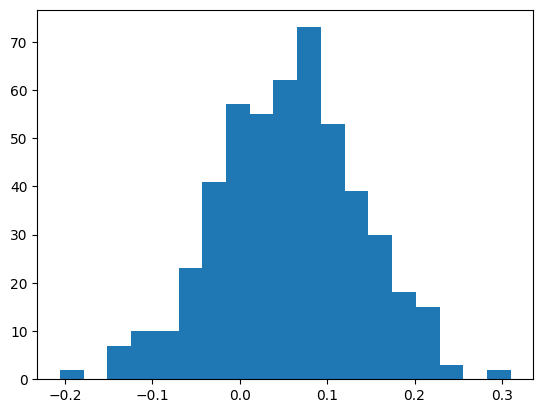

In [12]:
plt.figure()
plt.hist(samples["beta"], bins="auto")
plt.show()

In [566]:
Vmag = np.sqrt(samples["Vext_x"]**2 + samples["Vext_y"]**2 + samples["Vext_z"]**2)

V = np.vstack([samples["Vext_x"], samples["Vext_y"], samples["Vext_z"]]).T
V = csiborgtools.cartesian_to_radec(V)

l, b = csiborgtools.flow.radec_to_galactic(V[:, 1], V[:, 2])

KeyError: 'Vext_x'

In [543]:
print(f"|V|  = {np.mean(Vmag)} +- {np.std(Vmag)}")
print(f"l    = {np.mean(l)} +- {np.std(l)}")
print(f"b    = {np.mean(b)} +- {np.std(b)}")
print(f"beta = {np.mean(samples['beta'])} +- {np.std(samples['beta'])}")

|V|  = 39.12040328979492 +- 16.43771743774414
l    = 132.46352777972294 +- 97.08651704866757
b    = 3.6149575356618118 +- 34.07884951676805
beta = 0.2185758799314499 +- 0.062036316841840744


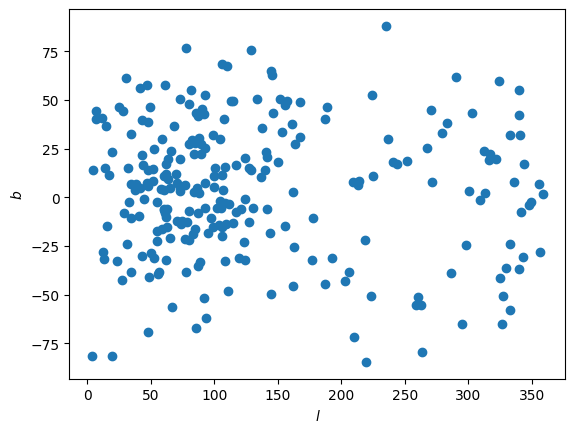

In [544]:
plt.figure()
plt.scatter(l, b)
plt.xlabel(r"$l$")
plt.ylabel(r"$b$")
plt.show()

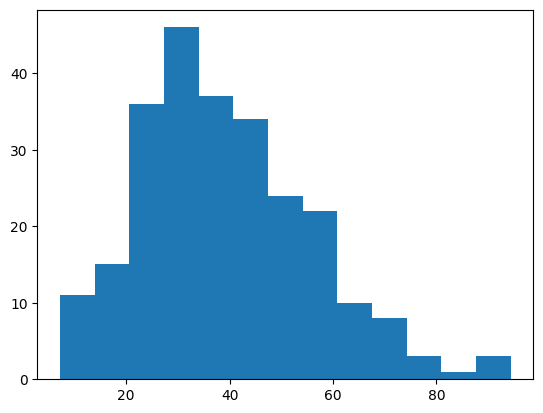

In [545]:
plt.figure()
plt.hist(V[:, 0], bins="auto")
plt.show()

In [337]:
data = np.vstack([samples["e_mu_intrinsic"], samples["beta"], l, b, Vmag]).T
labels = [r"$\sigma_\mu$", r"$\beta$", r"$l$", r"$b$", r"$|\bf{V}_{\rm ext}|$"]

KeyError: 'e_mu_intrinsic'

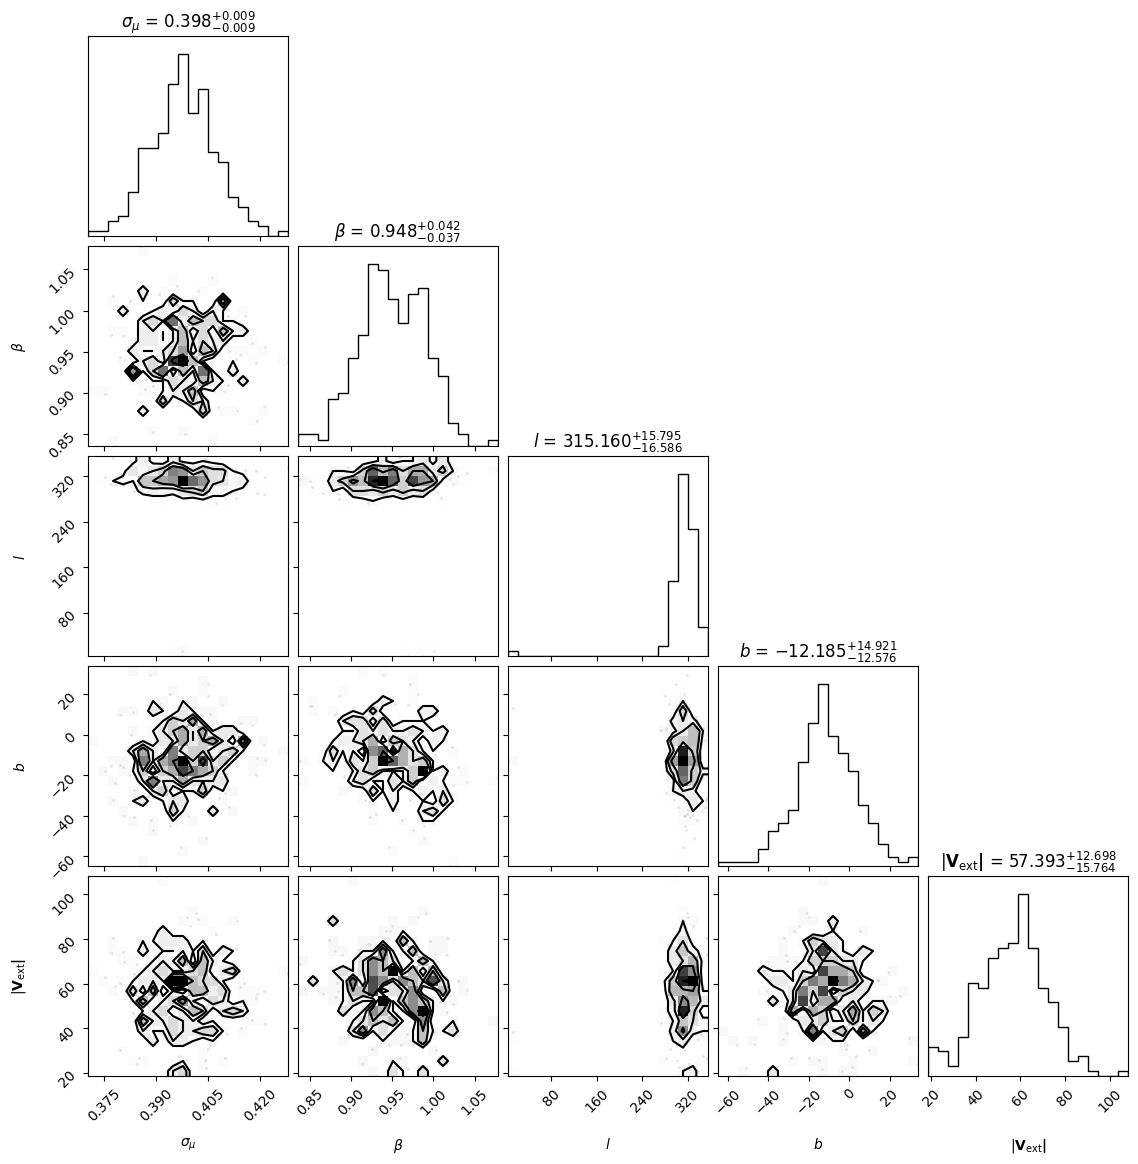

In [184]:
fig = corner.corner(data, labels=labels, show_titles=True, title_fmt=".3f", title_kwargs={"fontsize": 12})
# fig.savefig(f"../plots/corner.png", dpi=300, bbox_inches="tight")

## Vizualize the results

In [17]:
paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)
catalogue = "LOSS"
simname = "csiborg2_random"

nsims = paths.get_ics(simname)

Vx = []
Vy = []
Vz = []
beta = []
sigma_v = []
alpha = []

alpha_cal = []
beta_cal = []
mag_cal = []
e_mu_intrinsic = []


with File(f"/mnt/extraspace/rstiskalek/csiborg_postprocessing/peculiar_velocity/flow_samples_{catalogue}_{simname}_smooth_0.hdf5", 'r') as f:
    for i, nsim in enumerate(tqdm(nsims)):
        if i == 0:
            print(f[f"sim_{nsim}"].keys())

        Vx.append(f[f"sim_{nsim}/Vext_x"][:])
        Vy.append(f[f"sim_{nsim}/Vext_y"][:])
        Vz.append(f[f"sim_{nsim}/Vext_z"][:])
        alpha.append(f[f"sim_{nsim}/alpha"][:])
        beta.append(f[f"sim_{nsim}/beta"][:])
        sigma_v.append(f[f"sim_{nsim}/sigma_v"][:])

        alpha_cal.append(f[f"sim_{nsim}/alpha_cal"][:])
        beta_cal.append(f[f"sim_{nsim}/beta_cal"][:])
        mag_cal.append(f[f"sim_{nsim}/mag_cal"][:])
        e_mu_intrinsic.append(f[f"sim_{nsim}/e_mu_intrinsic"][:])

Vx = np.hstack(Vx)
Vy = np.hstack(Vy)
Vz = np.hstack(Vz)
alpha = np.hstack(alpha)
beta = np.hstack(beta)
sigma_v = np.hstack(sigma_v)

alpha_cal = np.hstack(alpha_cal)
beta_cal = np.hstack(beta_cal)
mag_cal = np.hstack(mag_cal)
e_mu_intrinsic = np.hstack(e_mu_intrinsic)

Vmag = np.sqrt(Vx**2 + Vy**2 + Vz**2)

V = np.vstack([Vx, Vy, Vz]).T
V = csiborgtools.cartesian_to_radec(V)
l, b = csiborgtools.flow.radec_to_galactic(V[:, 1], V[:, 2])


data = np.vstack([alpha, beta, Vmag, l, b, sigma_v, alpha_cal, beta_cal, mag_cal, e_mu_intrinsic]).T
labels = [r"$\alpha$", r"$\beta$", r"$|\bf{V}_{\rm ext}|$", r"$l$", r"$b$", r"$\sigma_v$", r"$\alpha_{\rm cal}$", r"$\beta_{\rm cal}$", r"$M$", r"$\sigma_\mu$"]

100%|██████████| 20/20 [00:00<00:00, 113.74it/s]


<KeysViewHDF5 ['Vext_x', 'Vext_y', 'Vext_z', 'alpha', 'alpha_cal', 'beta', 'beta_cal', 'e_mu_intrinsic', 'mag_cal', 'sigma_v']>


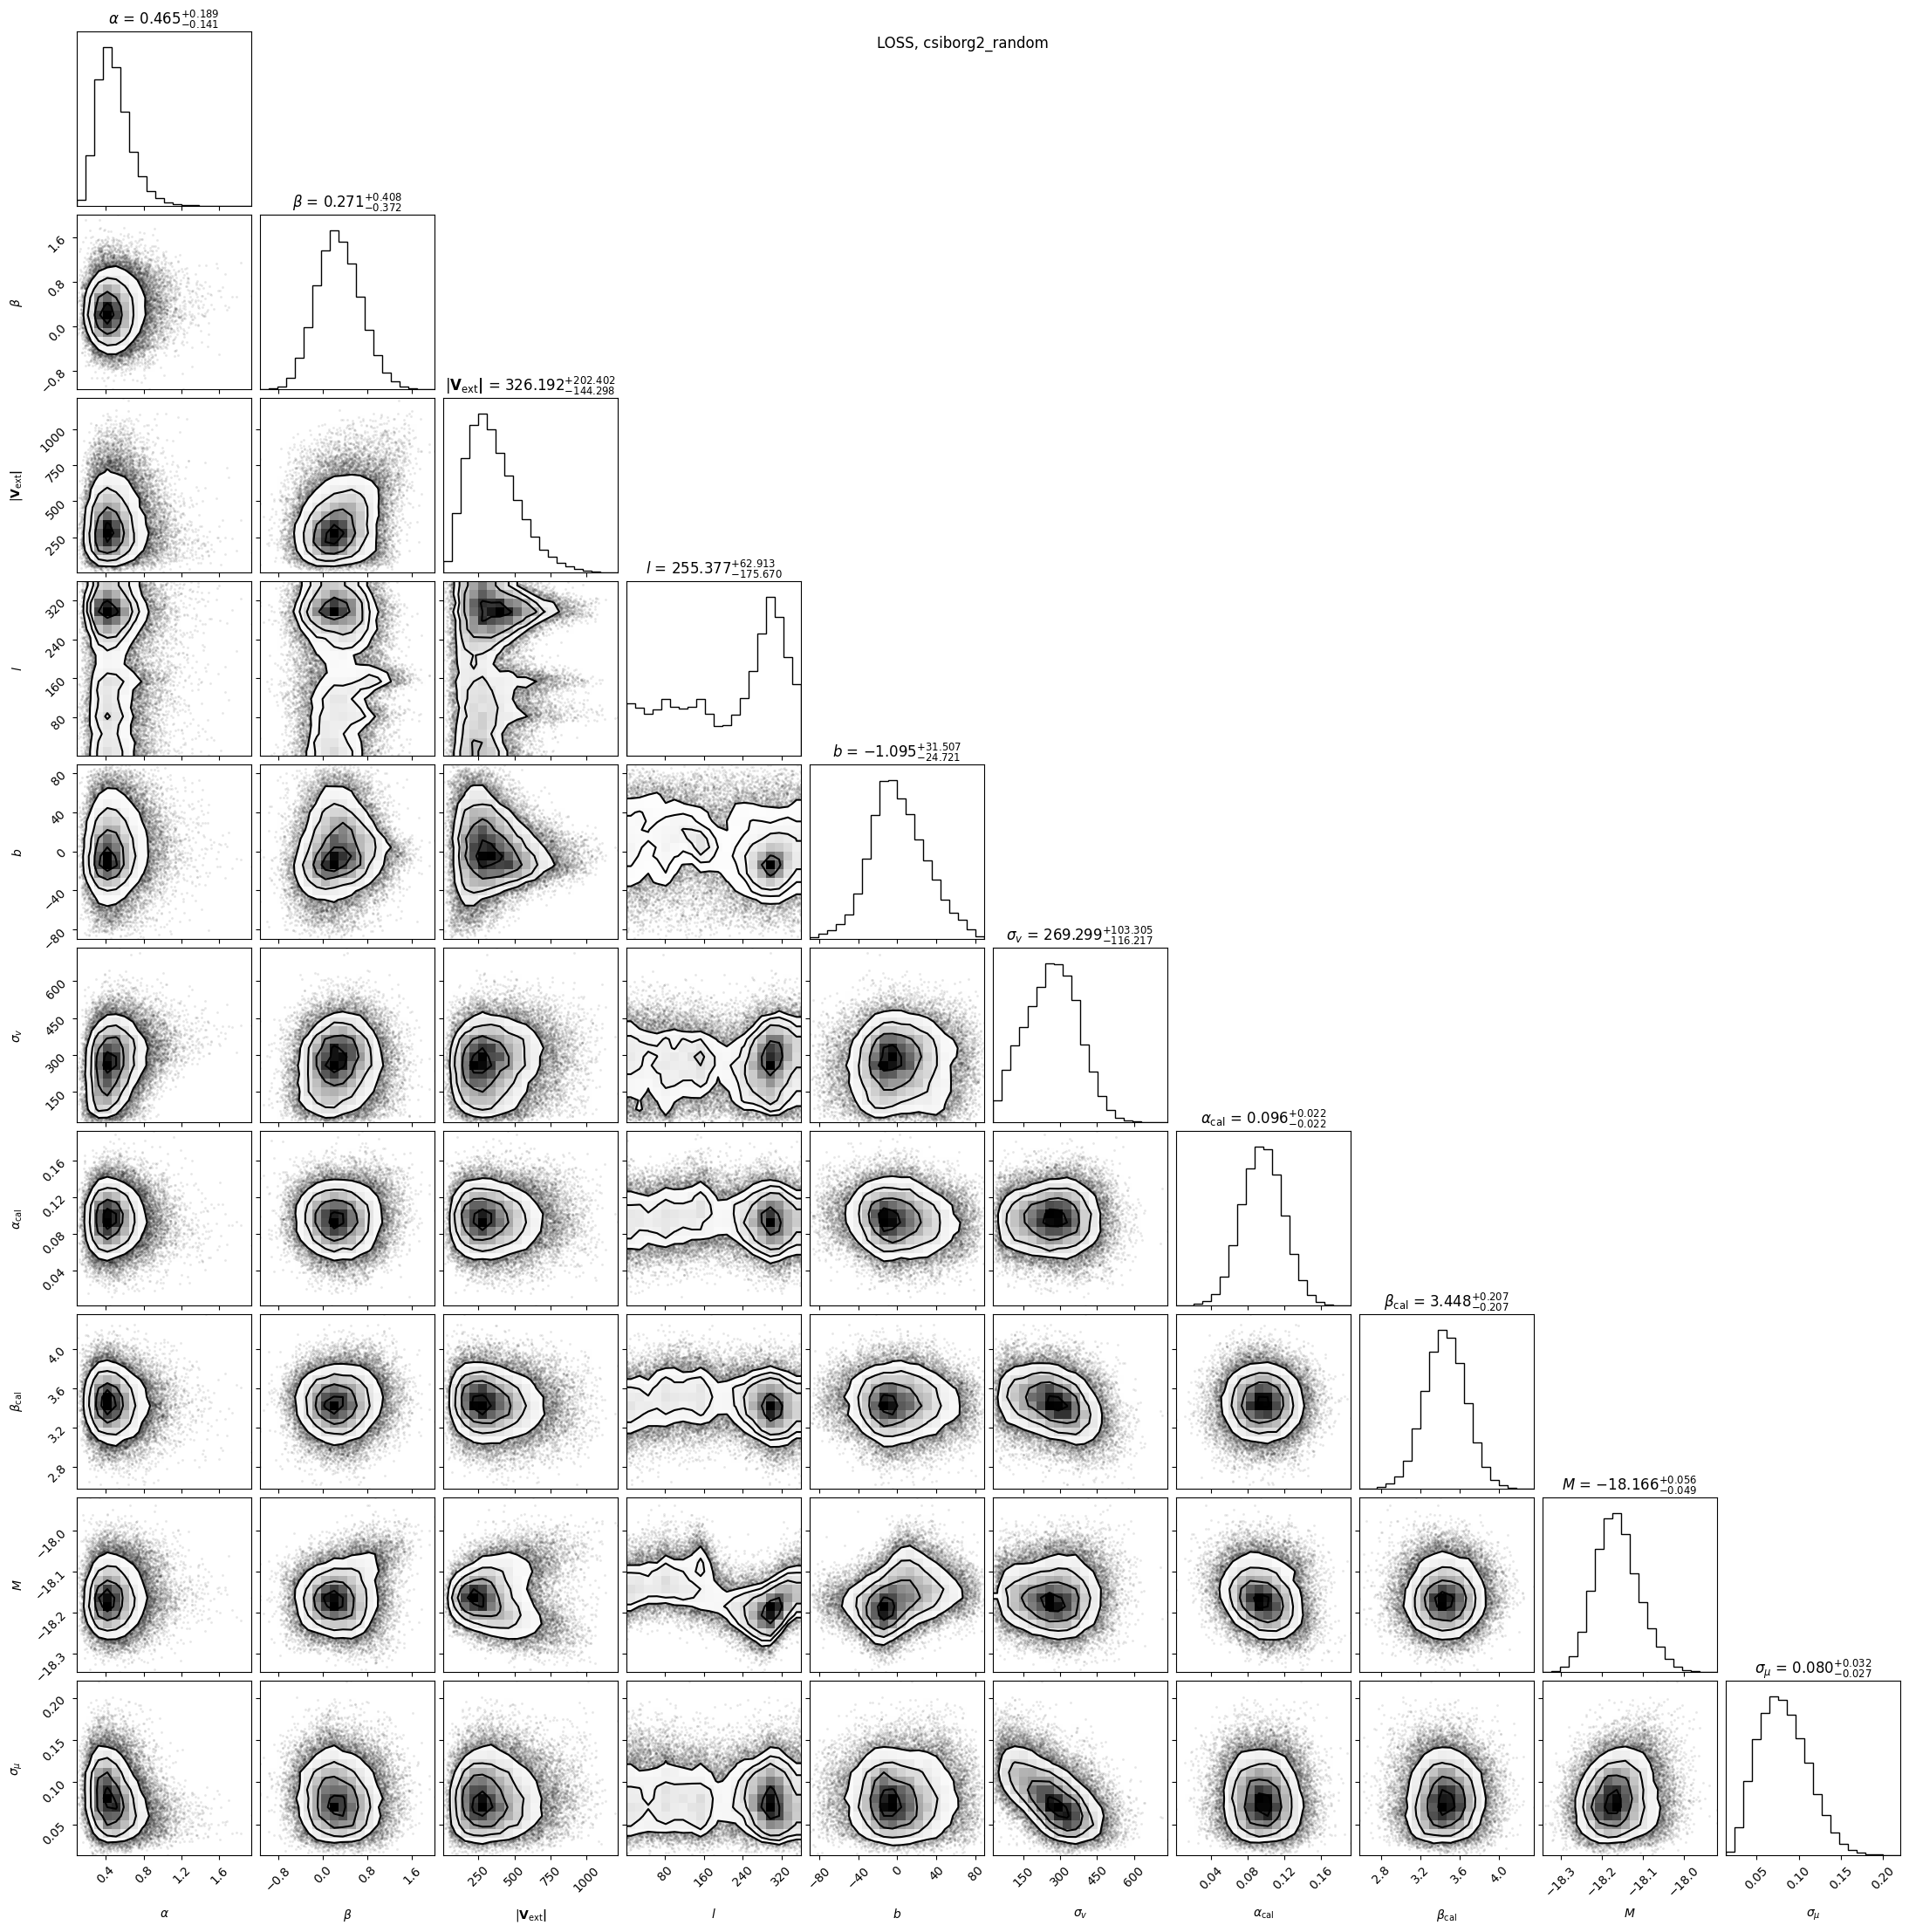

In [18]:
fig = corner.corner(data, labels=labels, show_titles=True, title_fmt=".3f", title_kwargs={"fontsize": 12})
fig.suptitle(f"{catalogue}, {simname}")
fig.savefig(f"../plots/corner_{catalogue}_{simname}.png", dpi=300, bbox_inches="tight")

In [210]:
np.mean(l)

294.53874356626227

In [299]:
0.906 * 0.43

0.38958

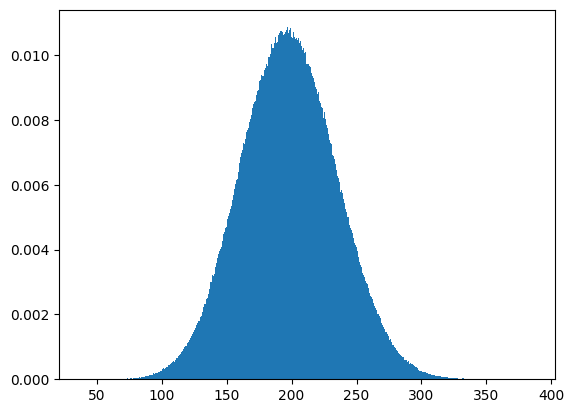

In [214]:
plt.figure()
plt.hist(V[:, 0], bins="auto", density=True)
plt.show()

In [219]:
print(beta.mean(), beta.std())
print(np.mean(V[:, 0]), np.std(V[:, 0]))
print(l.mean(), b.mean())

0.61461765 0.095553815
198.02641 36.928383
294.53874356626227 -5.542468825545464


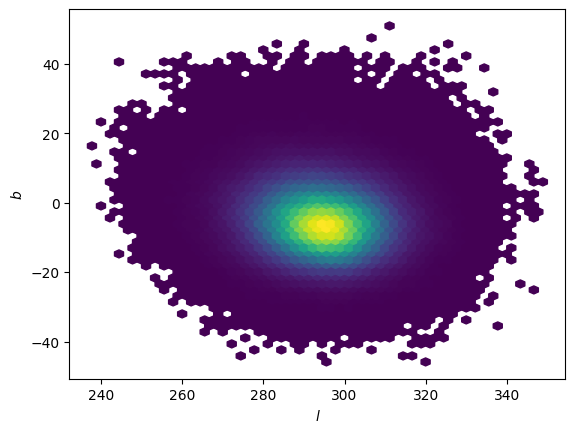

In [213]:
plt.figure()
plt.hexbin(l, b, gridsize=50, mincnt=1)
plt.xlabel(r"$l$")
plt.ylabel(r"$b$")
plt.show()

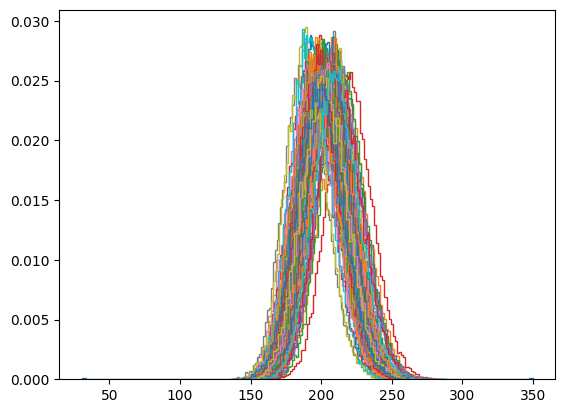

In [130]:
plt.figure()
for i in range(len(x)):
    plt.hist(x[i], bins="auto", density=True, histtype="step")

plt.show()

## Test bias

In [437]:
from jax.lax import cond

In [488]:


def bias(rho_norm, b):
    def bias_small(rho_norm, b):
        return jnp.log((1 + jnp.exp((1 - b + b * rho_norm))) / (1 + jnp.exp((1 - b))))

    def bias_large(rho_norm, b):
        return 1 - b + b * rho_norm - jnp.log(1 + jnp.exp(1 - b))

    return jnp.where(rho_norm < 3, 
                     bias_small(rho_norm, b), 
                     bias_large(rho_norm, b))

     

In [489]:
rho_norm = jnp.linspace(0, 100, 100)
b = 2
y = bias(rho_norm, b)

In [490]:
y

Array([  0.       ,   1.0148089,   2.7738497,   4.7473445,   6.767546 ,
         8.787747 ,  10.80795  ,  12.828152 ,  14.848353 ,  16.868557 ,
        18.888758 ,  20.90896  ,  22.929163 ,  24.949364 ,  26.969566 ,
        28.989767 ,  31.00997  ,  33.03017  ,  35.050373 ,  37.07057  ,
        39.090775 ,  41.110977 ,  43.13118  ,  45.151382 ,  47.171585 ,
        49.191784 ,  51.211987 ,  53.23219  ,  55.25239  ,  57.272594 ,
        59.292793 ,  61.312996 ,  63.3332   ,  65.3534   ,  67.373604 ,
        69.39381  ,  71.41401  ,  73.43421  ,  75.45441  ,  77.47461  ,
        79.49481  ,  81.515015 ,  83.53522  ,  85.55542  ,  87.57562  ,
        89.595825 ,  91.61603  ,  93.63623  ,  95.65643  ,  97.67663  ,
        99.69683  , 101.71703  , 103.737236 , 105.75744  , 107.77764  ,
       109.797844 , 111.81805  , 113.83825  , 115.85845  , 117.87865  ,
       119.89885  , 121.91905  , 123.939255 , 125.95946  , 127.97966  ,
       129.99986  , 132.02007  , 134.04027  , 136.06047  , 138.0

In [485]:
bias_small(rho_norm, b)

Array([ 0.       ,  1.0148089,  2.7738497,  4.753666 ,  6.768387 ,
        8.787859 , 10.807965 , 12.828154 , 14.848354 , 16.868557 ,
       18.888758 , 20.90896  , 22.929163 , 24.949364 , 26.969566 ,
       28.989767 , 31.00997  , 33.03017  , 35.050373 , 37.07057  ,
       39.090775 , 41.110977 , 43.13118  , 45.151382 , 47.171585 ,
       49.191784 , 51.211987 , 53.23219  , 55.25239  , 57.272594 ,
       59.292793 , 61.312996 , 63.3332   , 65.3534   , 67.373604 ,
       69.39381  , 71.41401  , 73.43421  , 75.45441  , 77.47461  ,
       79.49481  , 81.515015 , 83.53522  , 85.55542  , 87.57562  ,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        

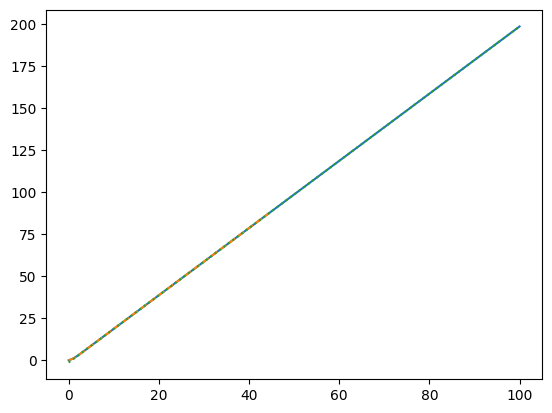

In [487]:
plt.figure()
plt.plot(rho_norm, y)
plt.plot(rho_norm, bias_small(rho_norm, b), ls="--")
plt.plot(rho_norm, bias_large(rho_norm, b), ls="dotted")
plt.show()

In [462]:
bias(loader._los_density[0], 2.)

Array([[1.3646735 , 1.434935  , 1.5887474 , 1.6949235 , 1.7769545 ,
        1.8709289 , 2.0290222 , 2.1513133 , 2.2334485 , 2.329708  ,
        2.444497  , 2.5160108 , 2.5457559 , 2.5692239 , 2.608365  ,
        2.6157517 , 2.5902514 , 2.5320826 , 2.4516525 , 2.3783646 ,
        2.3570633 , 2.2927842 , 2.235333  , 2.1849432 , 2.131144  ,
        2.1050715 , 2.1284485 , 2.1777897 , 2.2121887 , 2.2108288 ,
        2.2272425 , 2.2835732 , 2.2929268 , 2.2634182 , 2.241768  ,
        2.2274647 , 2.1347542 , 2.0022526 , 1.8764566 , 1.757152  ,
        1.5877327 , 1.4179734 , 1.2245289 , 1.0326    , 0.83725584,
        0.9779409 , 0.8560009 , 0.7459278 , 0.64249325, 0.5510863 ,
        0.4705007 , 0.40490875, 0.3523176 , 0.3036849 , 0.25979096,
        0.22670034, 0.2001784 , 0.17650758, 0.15544249, 0.1421564 ,
        0.1319982 , 0.12369715, 0.11719201, 0.11655279, 0.1178802 ,
        0.12243555, 0.12922992, 0.13944156, 0.15134403, 0.16509394,
        0.1822752 , 0.20241688, 0.22445495, 0.24

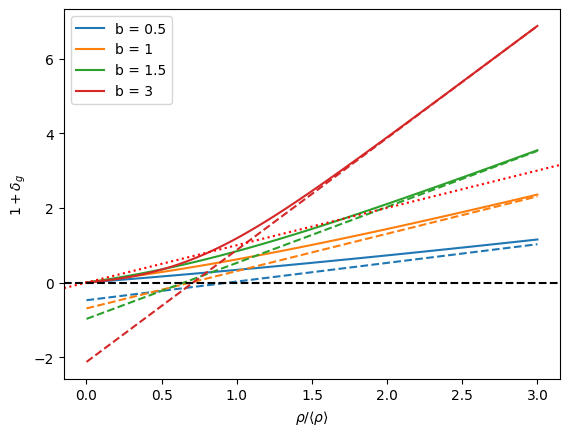

In [436]:
b = 1.4

rho = np.linspace(0, 3, 100)

def bias(rho, b):
    return np.log((1 + np.exp((1 - b + b * rho))) / (1 + np.exp((1 - b))))

def linear_bias(rho, b):
    return (1 - b + b * rho)

plt.figure()
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, b in enumerate([0.5, 1, 1.5, 3]):
    plt.plot(rho, bias(rho, b), label=f"b = {b}", c=cols[i])
    plt.plot(rho, 1 - b + b * rho - np.log(1 + np.exp(1 - b)), ls="--", c=cols[i])
    # plt.plot(rho, linear_bias(rho, b), ls="--", c=cols[i])
    

plt.axline((1, 1), slope=1, color="red", linestyle="dotted")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel(r"$\rho / \langle \rho \rangle$")
plt.ylabel(r"$1 + \delta_g$")
plt.legend()
plt.show()


In [133]:
 def get_field(kind):
    folder = "/mnt/extraspace/rstiskalek/catalogs"
    from os.path import join
    if kind == "density":
        fpath = join(folder, "twompp_density_carrick2015.npy")
        return np.load(fpath).astype(np.float32)
    elif kind == "velocity":
        fpath = join(folder, "twompp_velocity_carrick2015.npy")
        field = np.load(fpath).astype(np.float32)

        # Because the Carrick+2015 data is in the following form:
        # "The velocities are predicted peculiar velocities in the CMB
        # frame in Galactic Cartesian coordinates, generated from the
        # \(\delta_g^*\) field with \(\beta^* = 0.43\) and an external
        # dipole \(V_\mathrm{ext} = [89,-131,17]\) (Carrick et al Table 3)
        # has already been added.""
        field[0] -= 89
        field[1] -= -131
        field[2] -= 17
        field /= 0.43

        return field

In [135]:
density = get_field("density")
velocity = get_field("velocity")

In [136]:
from h5py import File

In [137]:
with File("/mnt/extraspace/rstiskalek/catalogs/Carrick2015_unscaled.hdf5", 'w') as f:
    f.create_dataset("density", data=density)
    f.create_dataset("velocity", data=velocity)
    